In [5]:
from unsloth import FastLanguageModel

from datasets import Dataset
from vllm import SamplingParams

In [6]:
import random
import json
import re
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sampling.sampling_fallacies_detection import load_all_dataset, sample_data, format_prompt

In [7]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.
paths = {
    'cocolofa': './Data_jsonl/cocolofa.jsonl',
    'mafalda': './Data_jsonl/mafalda.jsonl'
}

In [8]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name= "meta-llama/meta-Llama-3.1-8B-Instruct",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    fast_inference=True,
    gpu_memory_utilization=0.7
)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

==((====))==  Unsloth 2025.3.17: Fast Llama patching. Transformers: 4.50.0. vLLM: 0.7.2.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.451 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/meta-llama-3.1-8b-instruct-unsloth-bnb-4bit with actual GPU utilization = 26.51%
Unsloth: Your GPU has CUDA compute capability 8.6 with VRAM = 44.45 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 192.
Unsloth: vLLM's KV Cache can use up to 5.45 GB. Also swap space = 6 GB.
INFO 03-26 10:03:56 config.py:542] This model supports multiple tasks: {'score', 'classify', 'embed', 'generate', 'reward'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes confi

[W326 10:03:59.044446358 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 03-26 10:04:00 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 03-26 10:04:01 weight_utils.py:252] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-26 10:04:23 model_runner.py:1115] Loading model weights took 5.5976 GB
INFO 03-26 10:04:23 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-26 10:04:33 worker.py:267] Memory profiling takes 8.84 seconds
INFO 03-26 10:04:33 worker.py:267] the current vLLM instance can use total_gpu_memory (44.45GiB) x gpu_memory_utilization (0.27) = 11.79GiB
INFO 03-26 10:04:33 worker.py:267] model weights take 5.60GiB; non_torch_memory takes 0.06GiB; PyTorch activation peak memory takes 0.90GiB; the rest of the memory reserved for KV Cache is 5.23GiB.
INFO 03-26 10:04:34 executor_base.py:110] # CUDA blocks: 2675, # CPU blocks: 3072
INFO 03-26 10:04:34 executor_base.py:115] Maximum concurrency for 2048 tokens per request: 20.90x
INFO 03-26 10:04:46 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error oc

Capturing CUDA graph shapes: 100%|██████████| 27/27 [01:29<00:00,  3.30s/it]

INFO 03-26 10:06:15 model_runner.py:1562] Graph capturing finished in 89 secs, took 0.66 GiB
INFO 03-26 10:06:15 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 111.36 seconds



Unsloth 2025.3.17 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [9]:
SYSTEM_PROMPT = 'You are an expert in argumentation. Your task is to determine the type of fallacy in the given [SENTENCE]. The fallacy would be in the [FALLACY] Set. Utilize the [TITLE] and the [FULL TEXT] as context to support your decision.\nYour answer must be in the following format with only the fallacy in the answer section:\n<|ANSWER|><answer><|ANSWER|>.'

data = load_all_dataset(paths)
n_sample = 300
sampled_data, all_labels, stat_sample = sample_data(data, n_sample)
cpt = 0
for k,v in sampled_data.items():
    for i in v:
        cpt += 1
print(f'lenght sampled data: {cpt}')
prt = format_prompt(sampled_data, all_labels, SYSTEM_PROMPT)
df = pd.DataFrame().from_records(prt)

lenght sampled data: 300


In [10]:
def formatting_prompt(ex):
    text = tokenizer.apply_chat_template(ex.get('prompt'),tokenize = False, add_generation_prompt = False)
    return { 'text': text, }

data_ori = Dataset.from_pandas(df)
data_format = data_ori.map(formatting_prompt, batched=True)
data_format

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Dataset({
    features: ['datasets', 'prompt', 'answer', 'text'],
    num_rows: 401
})

In [11]:
def gen(txt, model, sampling_params):
    output = model.fast_generate(
        txt,
        sampling_params = sampling_params,
    )[0].outputs[0].text
    
    return output

def format_output(answer: str, fallacies: set) -> list:
    s = '<[|]ANSWER[|]>'
    tmp = re.split(s, answer)
    pred= [i for i in tmp if i in fallacies]
    return pred

def zero_shot_gen(data: list[str], model, fallacies: set, sampling_params) -> list:
    res = []
    for i in data:
        out = gen(i, model, sampling_params)
        pred = format_output(out, fallacies)
        res.append(pred)
    return res

FastLanguageModel.for_inference(model)
SAMPLING_PARAMS = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 128,
)
fallacies = all_labels

pred = zero_shot_gen(data_format['text'], model, fallacies, SAMPLING_PARAMS)

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it, est. speed input: 257.31 toks/s, output: 18.38 toks/s]


In [12]:
# To keep just in case
def get_precision(data, label):
    try:
        tmp = data.apply(lambda x: x['pred'] == label, axis=1)
        tp = tmp.value_counts().loc[True]
        precision = tp / len(tmp)
        fp = len(tmp) - tp
        return precision, tp, fp
    except (KeyError, ZeroDivisionError):
        tp = 0
        precision = 0
        fp = len(tmp) - tp
        return precision, tp, fp

def get_recall(data, label):
    try:
        tmp = data.apply(lambda x: x['pred'] == label, axis=1)
        tp = tmp.value_counts().loc[True]
        recall = tp / len(tmp)
        fn = len(tmp) - tp
        return recall, tp, fn
    except (KeyError, ZeroDivisionError):
        tp = 0
        recall = 0
        fn = len(tmp) - tp
        return recall, tp, fn
def get_metrics_old(data, all_labels):
    tp_preci = 0
    tp_rec = 0
    fn = 0
    fp = 0
    res = {}
    for l in all_labels:
        # df where pred == l
        df_pred = data[data['pred'] == l] 
        # df_lbl = data[data['lbl'] == l] 
        # df where gt == l
        df_lbl = data.apply(
            lambda x: x if l in x['lbl'].split(', ') else np.nan,
            axis=1,
            result_type='broadcast'
        )
        df_lbl = df_lbl.dropna()
        # correct pred of l in all the pred == l
        tmp_pred = df_pred.apply(
            lambda x: x['pred'] in x['lbl'].split(', ') and x['pred'] == l,
            axis=1
        )
        # correct pred of l where gt == l
        tmp_lbl = df_lbl.apply(
            lambda x: x['pred'] in x['lbl'].split(', ') and x['pred'] == l,
            axis=1
        )
        try:
            pred_lbl_c = tmp_pred.value_counts().loc[True]
        except KeyError:
            pred_lbl_c = 0
        try:
            lbl_pred_c = tmp_lbl.value_counts().loc[True]
        except KeyError:
            lbl_pred_c = 0
        fp += len(tmp_pred) - pred_lbl_c
        preci = pred_lbl_c / len(tmp_pred) if len(tmp_pred) != 0 else 0
        fn += len(tmp_lbl) - lbl_pred_c
        recall = lbl_pred_c / len(tmp_lbl)
        tp_preci += pred_lbl_c
        tp_rec += lbl_pred_c
        f1 = get_f1(preci, recall)
        res.update({l: (f1, preci, recall)})
    preci_glb = tp_preci / (tp_preci + fp)
    recall_glb = tp_rec / (tp_rec + fn)
    f1_glb = get_f1(preci_glb, recall_glb)
    res.update({'global': (f1_glb, preci_glb, recall_glb)})
    return res

In [ ]:
def get_precision_recall(data):
    try:
        tmp = data.apply(lambda x: x['pred'] == x['lbl'], axis=1)
        tp = tmp.value_counts().loc[True]
        score = tp / len(tmp)
        fp_fn = len(tmp) - tp
        return score, tp, fp_fn
    except (KeyError, ZeroDivisionError):
        tp = 0
        score = 0
        fp_fn = len(tmp) - tp
        return score, tp, fp_fn

def get_f1(precision, recall):
    try:
        f1 = 2 * ((precision * recall) / (precision + recall))
    except ZeroDivisionError:
        f1 = 0
    return f1

def get_metrics(data, labels):
    tp_preci = 0
    tp_rec = 0
    fn = 0
    fp = 0
    res = {}
    for l in labels:
        df_on_pred = data[data['pred'] == l]
        df_on_label = data[data['lbl'] == l]
        precision, tp_p, fp_p = get_precision_recall(df_on_pred)
        recall, tp_r, fn_r = get_precision_recall(df_on_label)
        f1 = get_f1(precision, recall)
        res.update({l: (f1, precision, recall)})
        fn += fn_r
        fp += fp_p
        tp_preci += tp_p
        tp_rec += tp_r
    precision_all_data = tp_preci / (tp_preci + fp)
    recall_all_data = tp_rec / (tp_rec + fn)
    f1_all_data = get_f1(precision_all_data, recall_all_data)
    res.update({
        'score_all_data': (f1_all_data, precision_all_data, recall_all_data)
    })
    return res

names_dataset = data_format['datasets']
true_labels = data_format['answer']

tmp_pred = [i if i != [] else ['Failed'] for i in pred]
try:
    df_pred = pd.read_csv('./pred_zero_shot.csv'),
    pred_flat = df_pred['PRED'].to_list()
except FileNotFoundError:
    df_pred = pd.DataFrame().from_records(tmp_pred)
    df_pred.to_csv('./pred_zero_shot.csv', index=False, header=['PRED'])
    pred_flat = list(itertools.chain.from_iterable(tmp_pred))

d_res = {'names': names_dataset, 'pred': pred_flat, 'lbl': true_labels}
df_res = pd.DataFrame(data=d_res)
df_res_cocolofa = df_res[df_res['names'] == 'cocolofa']
df_res_mafalda = df_res[df_res['names'] == 'mafalda']
metric = get_metrics(df_res, fallacies)
metric_cocolofa = get_metrics(df_res_cocolofa, fallacies)
metric_mafalda = get_metrics(df_res_mafalda, fallacies)

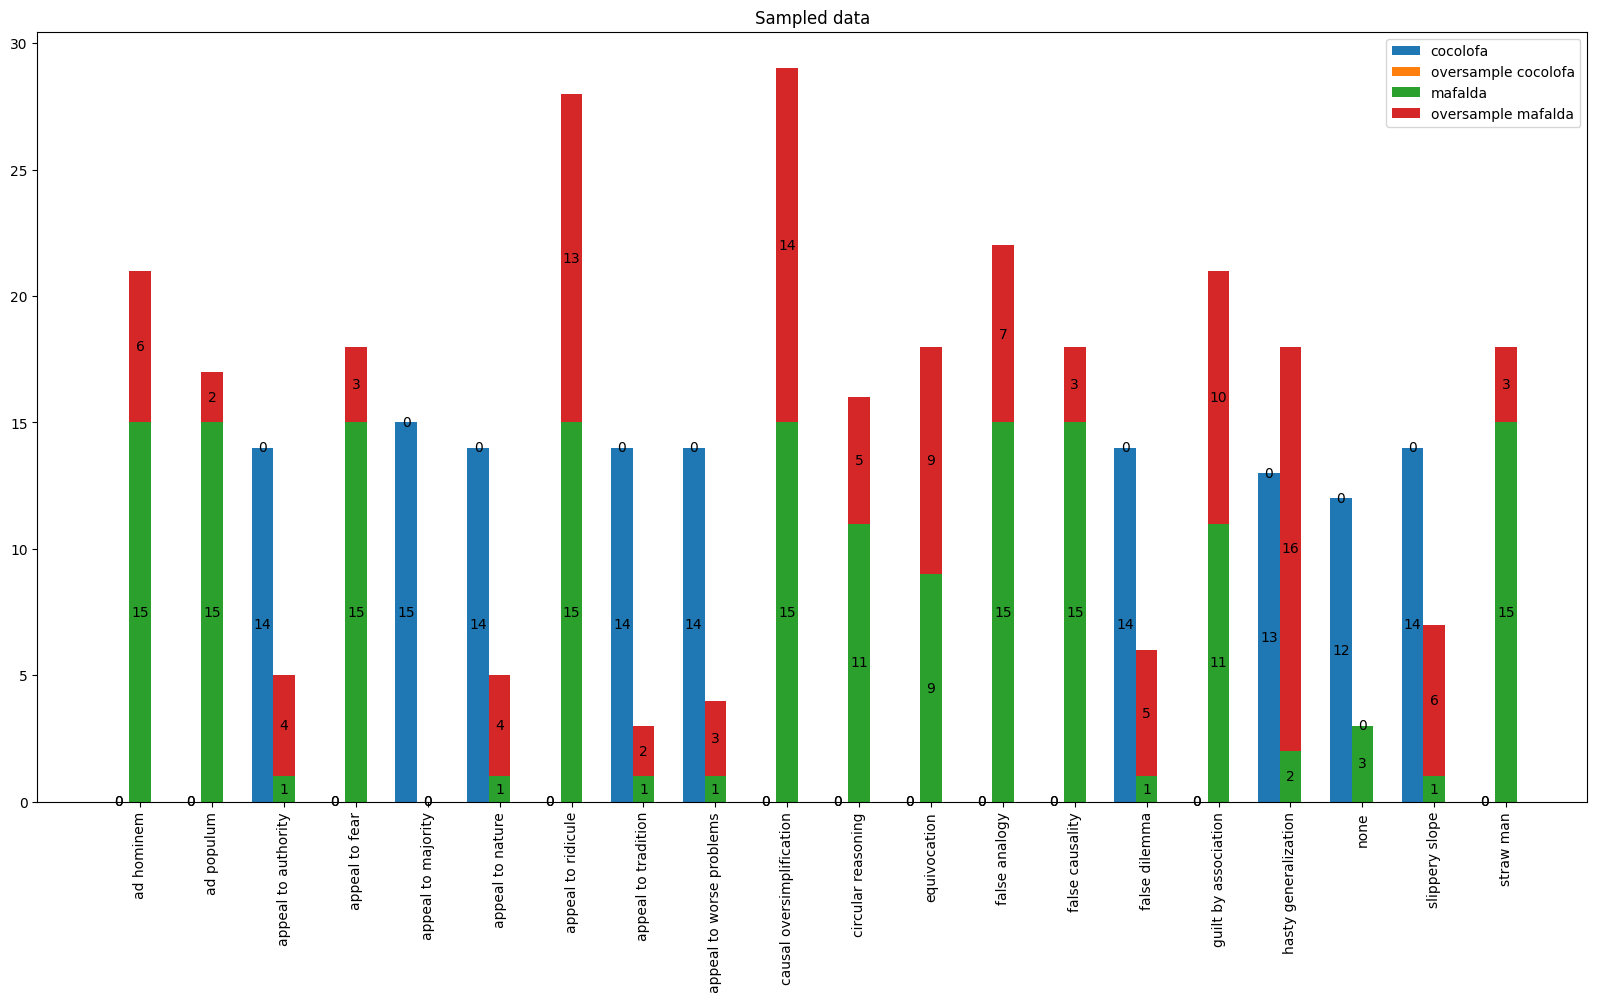

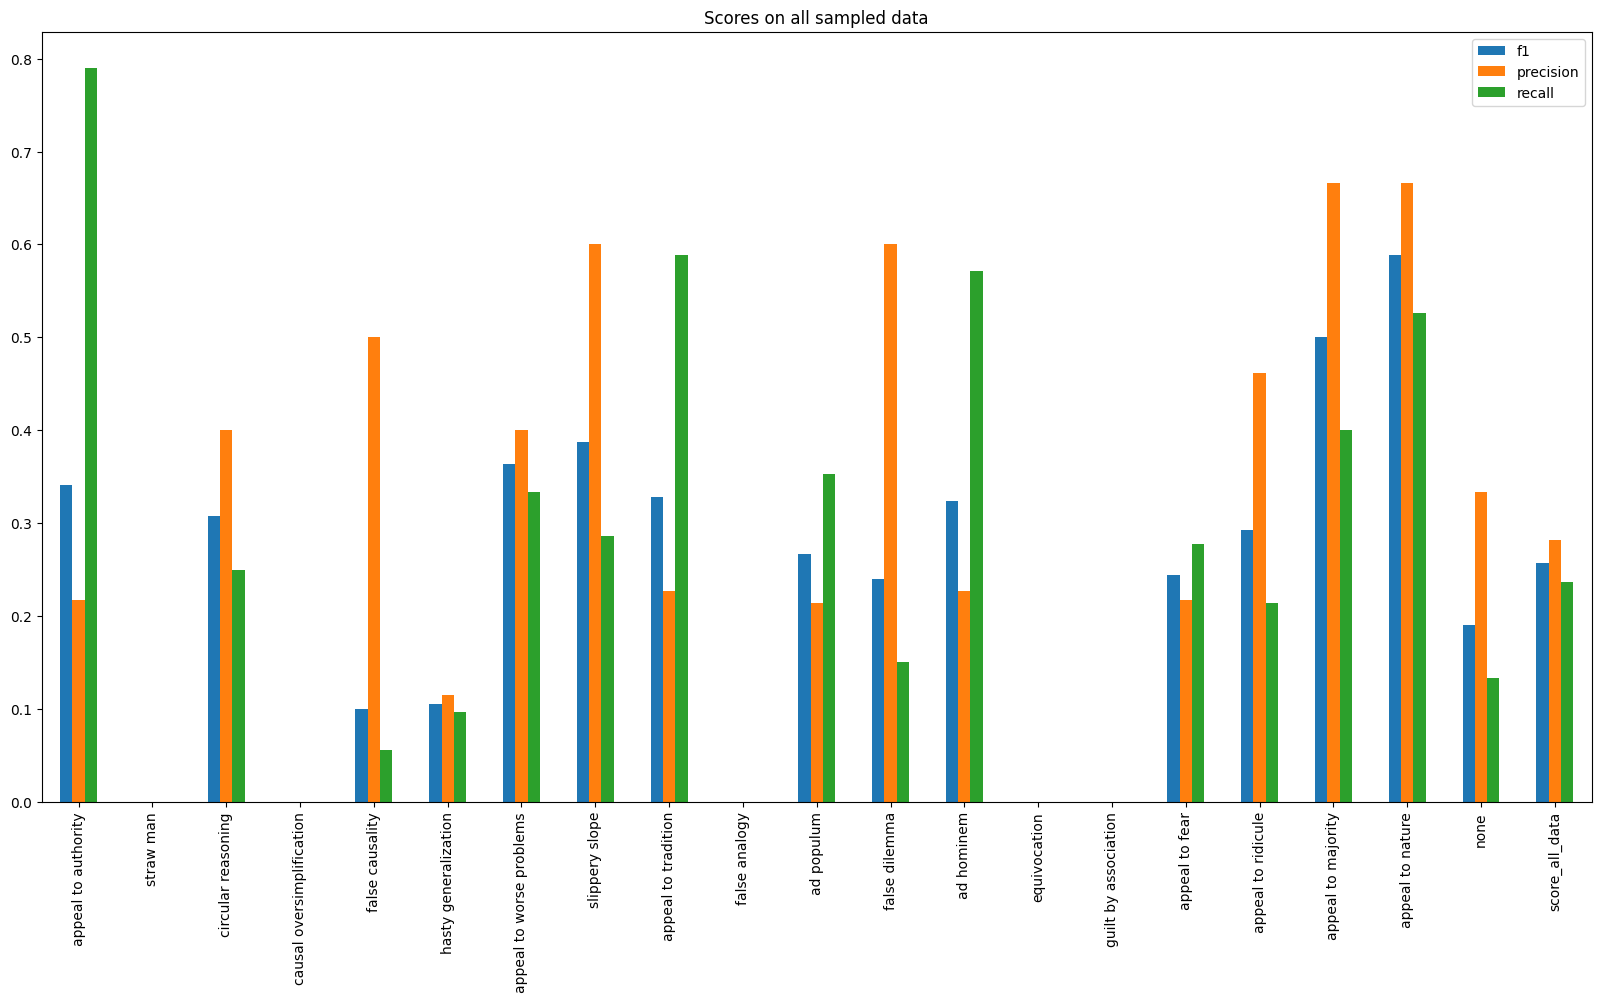

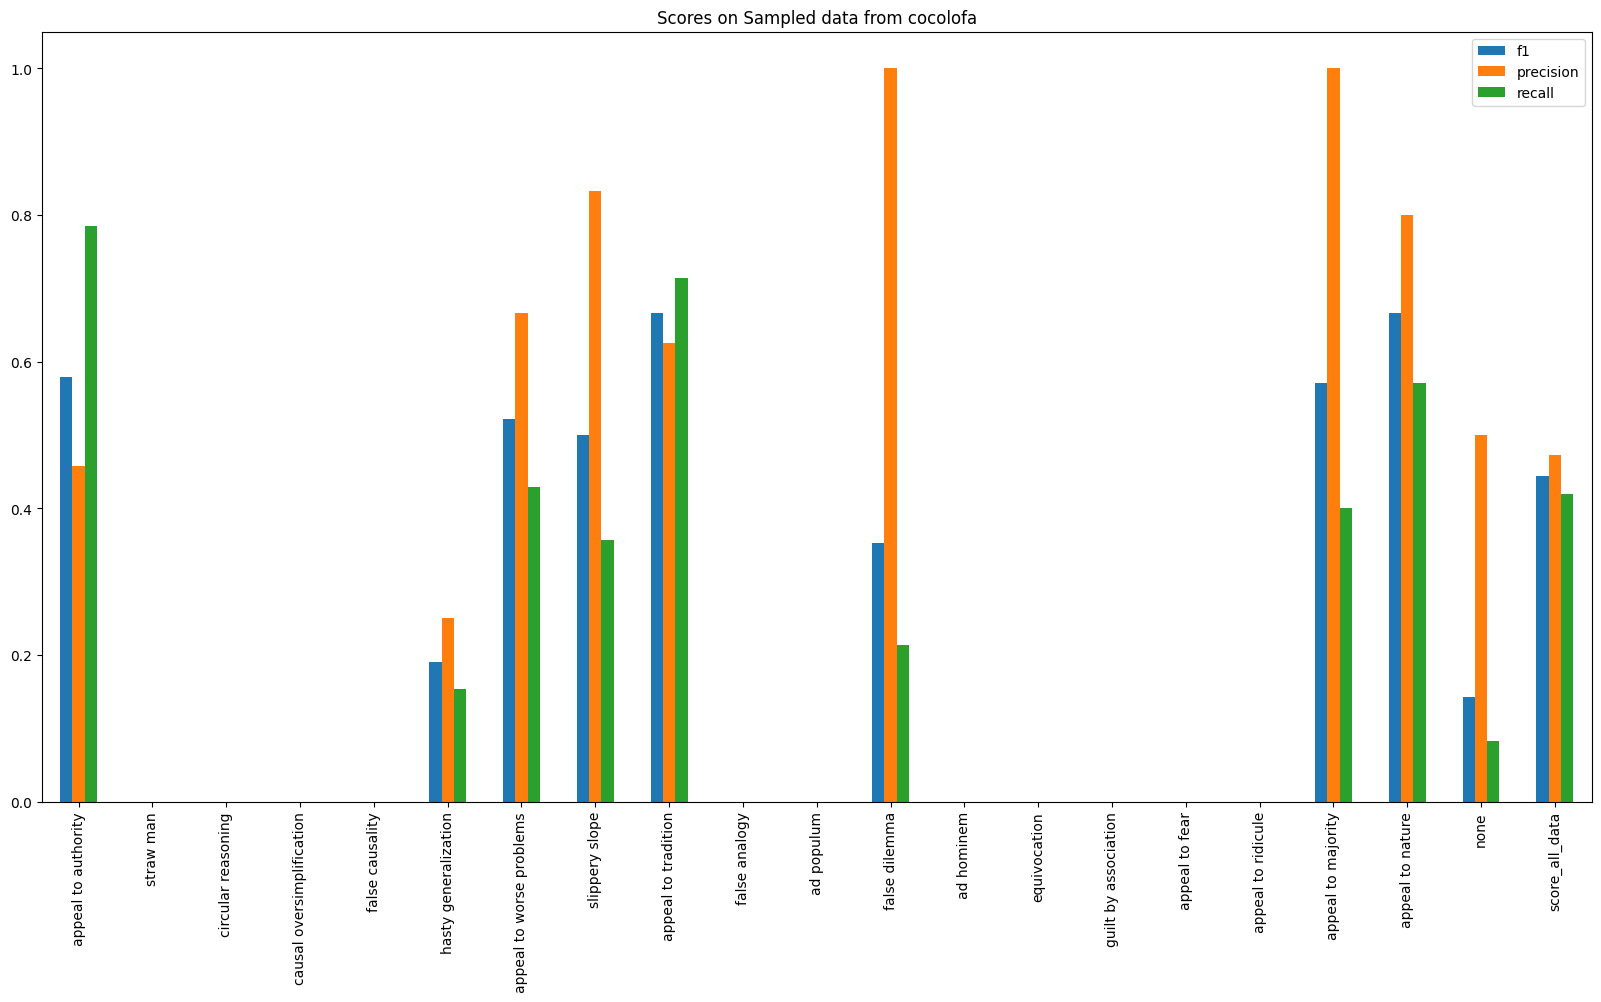

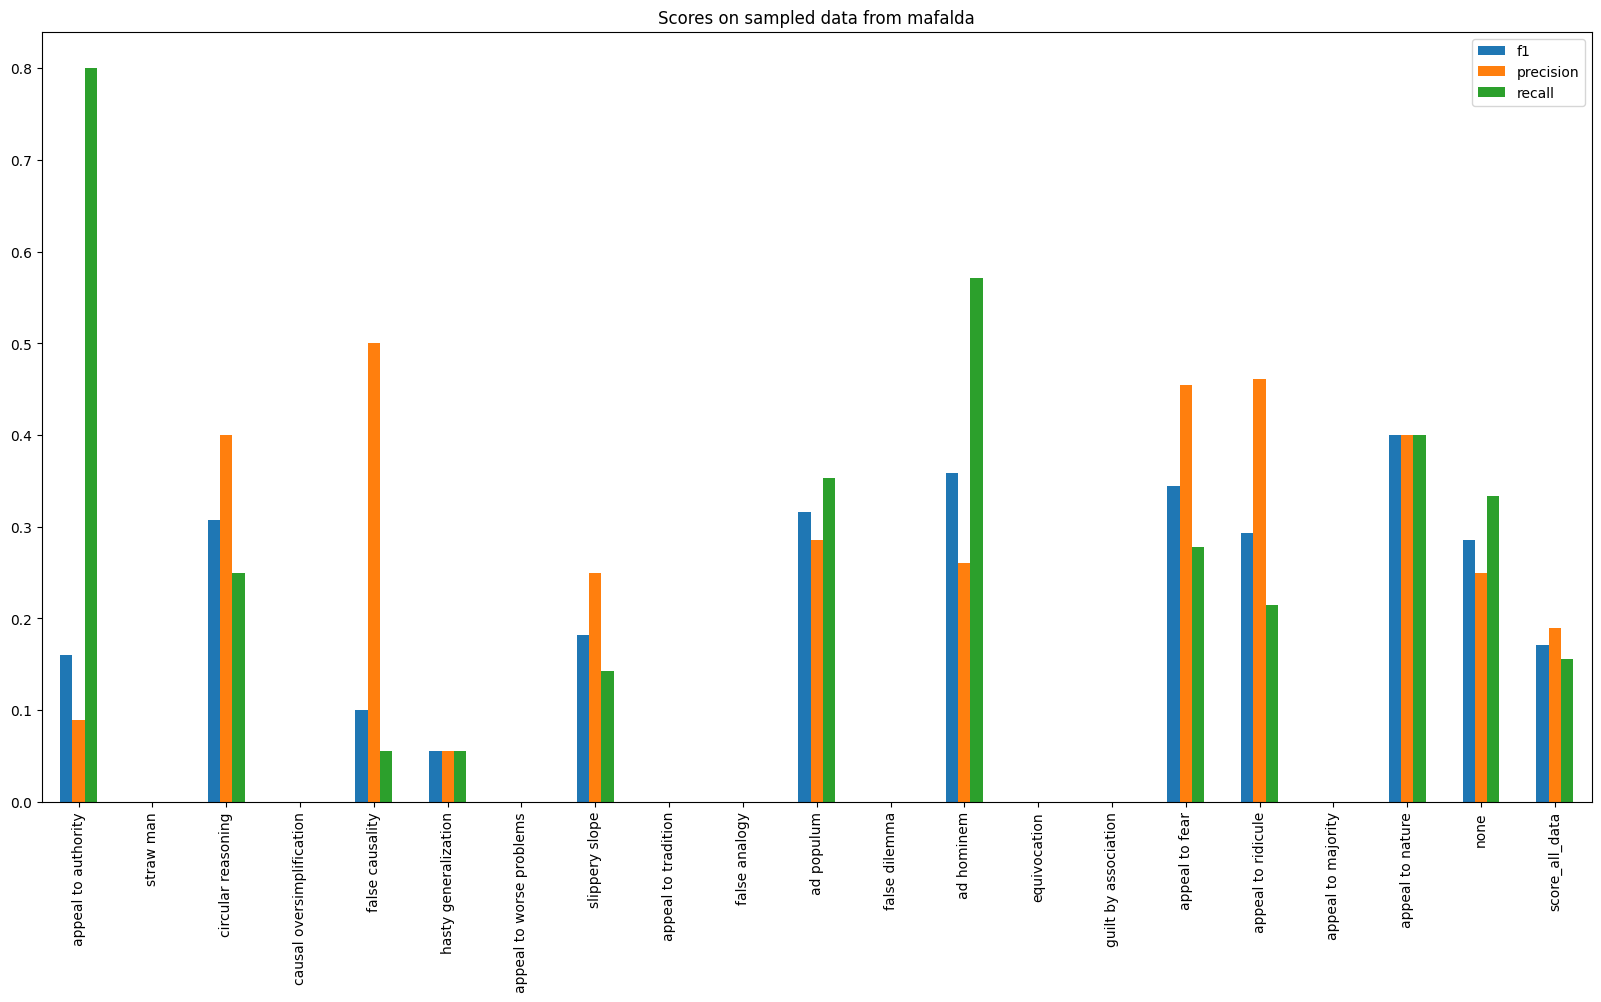

In [19]:
def plot_stat_sample(stat_sample: dict, prt_data: pd.DataFrame):
    width = 0.3
    df_cocolofa = prt_data[prt_data['datasets'] == 'cocolofa']
    df_mafalda = prt_data[prt_data['datasets'] == 'mafalda']
    nb_per_lbl = {
        'cocolofa': df_cocolofa['answer'].value_counts(),
        'mafalda': df_mafalda['answer'].value_counts()
    }
    df_nb_lbl = pd.DataFrame().from_dict(
        nb_per_lbl, orient='index'
    ).fillna(0).T.sort_index().astype('int32')
    df_sample_length = pd.DataFrame().from_dict(
        stat_sample.get('sample_per_label'),
        orient='index'
    ).T.sort_index()
    df_oversample_length = pd.DataFrame().from_dict(
        stat_sample.get('oversample_per_label'),
        orient='index'
    ).T.sort_index()
    under_cocolofa = (
        df_sample_length['cocolofa'] - df_oversample_length['cocolofa']
    ).to_list()
    over_cocolofa = (
        df_nb_lbl['cocolofa'] - df_sample_length['cocolofa'] 
        + df_oversample_length['cocolofa']
    ).to_list()
    under_mafalda = (
        df_sample_length['mafalda'] - df_oversample_length['mafalda']
    ).to_list()
    over_mafalda = (
        df_nb_lbl['mafalda'] - df_sample_length['mafalda'] 
        + df_oversample_length['mafalda']
    ).to_list()
    fig,ax = plt.subplots()
    x = np.arange(len(all_labels))
    p = ax.bar(x + width*0, under_cocolofa, width, label='cocolofa')
    ax.bar_label(p, label_type='center')
    p = ax.bar(x + width*0, over_cocolofa, width, label='oversample cocolofa',  bottom=under_cocolofa)#, hatch='x')
    ax.bar_label(p, label_type='center')
    p = ax.bar(x + width*1, under_mafalda, width, label='mafalda')
    ax.bar_label(p, label_type='center')
    p = ax.bar(x + width*1, over_mafalda, width, label='oversample mafalda',    bottom=under_mafalda)#, hatch='x', alpha=0.5)
    ax.bar_label(p, label_type='center')
    ax.set_xticks(x + width, sorted(all_labels), rotation=90)
    ax.legend(loc='upper right')
    ax.set_title('Sampled data')
    fig.set_size_inches(20, 10)
    plt.show()

def plot_metric(
    metric: dict,
    columns: list[str]=['f1', 'precision', 'recall'],
    title=''
):
    # rand_mark = pd.Series(np.full((len(metric),), 1/(len(metric)-1)))
    df_metric = pd.DataFrame().from_dict(
        metric,
        orient='index',
        columns=columns
    )
    fig, ax = plt.subplots(1, 1)
    df_metric.plot(
        ax=ax,
        kind='bar',
        figsize=(20,10),
        title=title,
    )
    # rand_mark.plot(ax=ax, color='red', linestyle='dashed')
    plt.xticks(rotation=90)
    
columns = ['f1', 'precision', 'recall']

plot_stat_sample(stat_sample, df)
plot_metric(metric, title='Scores on all sampled data')
plot_metric(metric_cocolofa, title='Scores on Sampled data from cocolofa')
plot_metric(metric_mafalda, title='Scores on sampled data from mafalda')